# Final Project Part 2
### By Samuel Karp
## Source
- Source https://archive.ics.uci.edu/ml/datasets/bank+marketing
- Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014
---

### Index
- [Goal](#goal)
- [Import The Data and Clean](#import)
- [Getting a Breif overview of the data's structure and describing it](#overview)
- [Evaluation of data, Missing Data and Other Notes](#evaluation)
- [Plan and Questions](#plan_questions)
- [Cleaning and Encoding](#cleaning)
- [LR prep and model](#logit-prep)
- [Standardizing features and GS to find best alpha](#gridsearch)
- [Findings](#findings)

<a id='goal' ></a>

## Goal
### Predict if a client will subscribe a term deposit. 
#### But, what does this mean?
- Will a person whom is already banking with this Portuguese banking institution want to invest money with the bank as a 'term deposit'?
- Our outcome will be the probability of a client subscribing to a term deposit
---
- Hypothesis: A client will subscribe a term deposit
- Null Hypothesis: A client will not subscribe a term deposit

In [2]:
#General imports
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

<a id='import' ></a>

## Import the Sample Dataset and Clean
---
### Import the dataset
#### Here I import the dataset and view it to begin understanding what the different features and types of variables exist
- Import dataset and view head

In [3]:
bank_data = pd.read_csv('../Data/bank.csv', sep=";") #Seperate by ";" or the clean after import. This is easier
print bank_data.head()

   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  


### Clean the dataset
- Replace the unwanted characters in the dataset

In [4]:
bank_data.columns = [x.replace('"', '\'') for x in bank_data.columns]
bank_data.columns

Index([u'age', u'job', u'marital', u'education', u'default', u'balance',
       u'housing', u'loan', u'contact', u'day', u'month', u'duration',
       u'campaign', u'pdays', u'previous', u'poutcome', u'y'],
      dtype='object')

In [5]:
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


<a id='overview'></a>

## Overview of the dataset
---
Here I will discuss the features of the dataset, possible missing data, problems that may occur due to the types are structure of the features and possible methods of resolution

The features are split into 5 categories:
   - Bank Client Data
   - Related with last contact of the current campaign
   - Other Attributes
   - Social and economic context attributes
   - Finally, the target
   
#### Bank client data:
| Variable | Description |
|---|---|
| age | numeric, continuous |
| job | type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown") |
| marital | marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed) |
| education | (categorical: "high.school","illiterate","professional.course","university.degree","unknown") |
| default | has credit in default? (categorical: "no","yes","unknown") |
| balance | numeric, continuous. Funds in client's account |
| housing | has housing loan? (categorical: "no","yes","unknown") |
| loan | has personal loan? (categorical: "no","yes","unknown") |

#### Related with the last contact of the current campaign:
| Variable | Description |
|---|---|
| contact | contact communication type (categorical: "cellular","telephone")  |
| month | last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec") |
| day_of_week | last contact day of the week (categorical: "mon","tue","wed","thu","fri") |
| duration | last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model |

#### Other attributes:
| Variable | Description |
|---|---|
| campaign | number of contacts performed during this campaign and for this client (numeric, includes last contact)
| pdays | number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) |
| previous | number of contacts performed before this campaign and for this client (numeric) |
| poutcome: outcome of the previous marketing campaign (categorical | "failure","nonexistent","success") |

#### Social and economic context attributes
| Variable | Description |
|---|---|
| emp.var.rate: employment variation rate | quarterly indicator (numeric) |
| cons.price.idx: consumer price index | monthly indicator (numeric) |    
| cons.conf.idx: consumer confidence index | monthly indicator (numeric) |    
| euribor3m: euribor 3 month rate | daily indicator (numeric) |
| nr.employed: number of employees | quarterly indicator (numeric) |
#### Target
y - has the client subscribed a term deposit? (binary: "yes","no")

<a id='evaluation'></a>

## Evaluation of the data, Missing Data and Other Notes

In [6]:
bank_data.education.value_counts() #The feature table above describes different categories available to 'education'
#This data must have been cleaned to reduce noise

secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64

### Note about duration
There is a strong correlation between duration and the target, however duration is unknown until the call is completed. This feature will not be used in model prediction. A similar opinion was stated by S. Moro, P. Cortez and P. Rita in their paper; A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014. "we only achieved good models when using attributes that are only known on call execution, such as call duration. Thus, while providing interesting information for campaign managers, such models cannot be used for prediction." I do not have the duration of a call until the call is finished, and I have the output at the same time. The duration of a call is unknown until the call is executed, therefore it cannot be used to predict future outcomes

#### Missing Features or Incomplete features
- Interest Rate, which would describe the interest rates offered

- Considering we can have multiple calls, balances is without a proper definition. I will treat this as the funds in the client's account when they were last called.

- Any observation with an 'unknown' feature may have to be removed from the dataset as having a client with an 'unknown' property will not provide any clarity on a prediction. However, removing a client with 'unknown' age (which may be a very low impact feature) could remove a client that has 'y' as yes. I believe retaining the unknowns and treating them as a category is the best option

- The social and economic factors in the feature list are not present in the data, likely because they are confidential. 

- Other features such as gender are not in the dataset

#### Characteristics of the Dataset
- Multivariate
- Classification variables
- Continuous Variables

<a id='plan_questions'></a>

## Plan
- In order to begin using the data I must think of the features that need to be encoded or dummyfied.

- Inspect different features for collinearity
- Plot a heat map to inspect for high correlating features
- Use gridsearch and lasso to reduce dimensionality of the data
- Use logisitic regression to predict the probability of my hypothesis and null hypothesis since there is a dichotomous outcome
- Could also use random forests as they are robust against unknown or missing data, with a plesant visual output

## Questions
- How will unknown data affect my predictive ability?
- How will missing data affect my data and how should I address it? Feature extraction?
- What features have the highest impact on the target?

# End of Part 2
---
## Begin the EDA

In [7]:
bank_data.education.value_counts()

secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64

In [8]:
bank_data['y'].value_counts()

no     4000
yes     521
Name: y, dtype: int64

In [9]:
bank_data['job'].value_counts()#a good way of showing the breakdown of distinct values in a column. Use in EDA

management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: job, dtype: int64

In [10]:
print bank_data.mean()
print bank_data.std()
print bank_data.var()

age           41.170095
balance     1422.657819
day           15.915284
duration     263.961292
campaign       2.793630
pdays         39.766645
previous       0.542579
dtype: float64
age           10.576211
balance     3009.638142
day            8.247667
duration     259.856633
campaign       3.109807
pdays        100.121124
previous       1.693562
dtype: float64
age         1.118562e+02
balance     9.057922e+06
day         6.802402e+01
duration    6.752547e+04
campaign    9.670897e+00
pdays       1.002424e+04
previous    2.868153e+00
dtype: float64


In [11]:
des = bank_data.groupby('job').describe()
des.campaign

,count,mean,std,min,25%,50%,75%,max
job,,,,,,,,
admin.,478.0,2.631799,2.818476,1.0,1.0,2.0,3.0,32.0
blue-collar,946.0,2.846723,3.500684,1.0,1.0,2.0,3.0,50.0
entrepreneur,168.0,2.589286,2.727835,1.0,1.0,2.0,3.0,24.0
housemaid,112.0,2.500000,1.815846,1.0,1.0,2.0,3.0,11.0
management,969.0,2.973168,3.196606,1.0,1.0,2.0,3.0,29.0
retired,230.0,2.465217,2.491226,1.0,1.0,2.0,3.0,23.0
self-employed,183.0,3.278689,4.154163,1.0,1.0,2.0,4.0,32.0
services,417.0,2.822542,3.222095,1.0,1.0,2.0,3.0,28.0
student,84.0,2.392857,2.583627,1.0,1.0,2.0,3.0,18.0


In [12]:
print bank_data.groupby('y').mean()
print bank_data.groupby('y').std()

           age      balance        day    duration  campaign      pdays  \
y                                                                         
no   40.998000  1403.211750  15.948750  226.347500  2.862250  36.006000   
yes  42.491363  1571.955854  15.658349  552.742802  2.266795  68.639155   

     previous  
y              
no   0.471250  
yes  1.090211  
           age      balance       day    duration  campaign       pdays  \
y                                                                         
no   10.188398  3075.349313  8.249736  210.313631  3.212609   96.297657   
yes  13.115772  2444.398956  8.235148  390.325805  2.092071  121.963063   

     previous  
y              
no   1.627371  
yes  2.055368  


In [13]:
employment = bank_data.job
durr = bank_data.duration

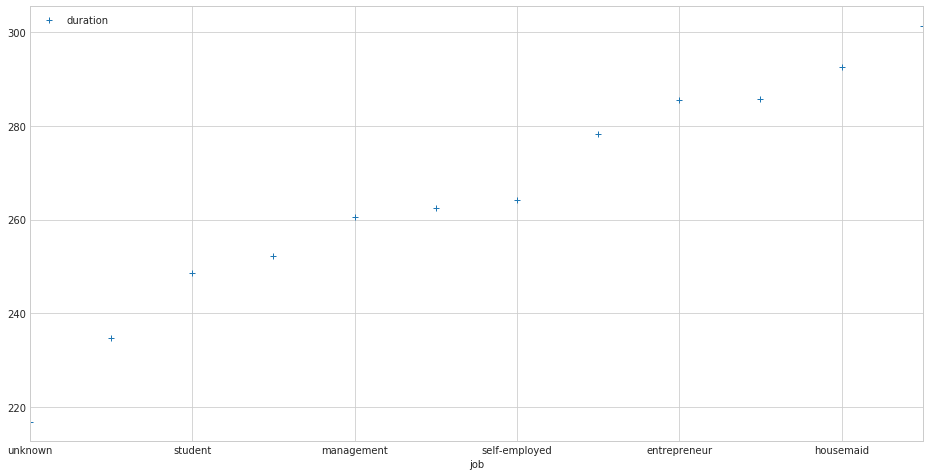

In [14]:
bank_data[['job', 'duration']].groupby('job').mean().sort_values('duration').plot(style='+', figsize=(16, 8))

In [15]:
bank_data['education'].value_counts()

secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64

<a id='cleaning'></a>
# Cleaning and Encoding Features 
---
- Encode features so they can be used in logistic regression

In [16]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
d = defaultdict(LabelEncoder)

In [17]:
bank_data.poutcome.unique()#Outcome of previous campaign effort. Other and unknown would achieve the same result.

array(['unknown', 'failure', 'other', 'success'], dtype=object)

### Features to encode:
- job
- marital
- education
- default
- housing
- loan
- contact
- month
- poutcome
- y

In [18]:
#Removing 'other' from feature poutcome
#Transform y yes/no to has_subscribed 1/0
bank_data.poutcome = bank_data.poutcome.apply(lambda x: 'unknown' if x == 'other' else x)

bank_data['y'] = bank_data.y.apply(lambda x: 1 if x == 'yes' else 0)

In [19]:
new_df = bank_data.apply(lambda x: d[x.name].fit_transform(x))

In [20]:
print new_df.head()

   age  job  marital  education  default  balance  housing  loan  contact  \
0   11   10        1          0        0     1475        0     0        0   
1   14    7        1          1        0     2030        1     1        0   
2   16    4        2          2        0     1303        1     0        0   
3   11    4        1          2        0     1352        1     1        2   
4   40    1        1          1        0      274        1     0        2   

   day  month  duration  campaign  pdays  previous  poutcome  y  
0   18     10        75         0      0         0         2  0  
1   10      8       216         0    228         4         0  0  
2   15      0       181         0    219         1         0  0  
3    2      6       195         3      0         0         2  0  
4    4      8       222         0      0         0         2  0  


In [21]:
print new_df.apply(lambda x: d[x.name].inverse_transform(x))

      age            job   marital  education default  balance housing loan  \
0      30     unemployed   married    primary      no     1787      no   no   
1      33       services   married  secondary      no     4789     yes  yes   
2      35     management    single   tertiary      no     1350     yes   no   
3      30     management   married   tertiary      no     1476     yes  yes   
4      59    blue-collar   married  secondary      no        0     yes   no   
5      35     management    single   tertiary      no      747      no   no   
6      36  self-employed   married   tertiary      no      307     yes   no   
7      39     technician   married  secondary      no      147     yes   no   
8      41   entrepreneur   married   tertiary      no      221     yes   no   
9      43       services   married    primary      no      -88     yes  yes   
10     39       services   married  secondary      no     9374     yes   no   
11     43         admin.   married  secondary      n

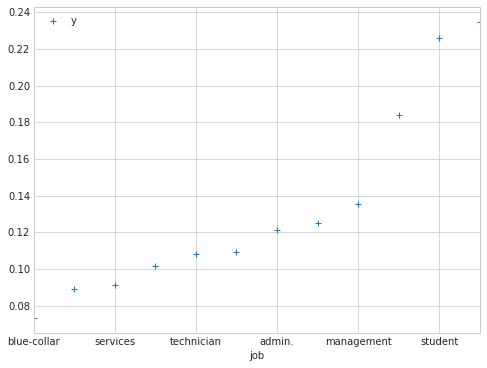

In [22]:
bank_data[['job', 'y']].groupby('job').mean().sort_values('y').plot(style='+', figsize=(8, 6))

In [23]:
new_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,11,10,1,0,0,1475,0,0,0,18,10,75,0,0,0,2,0
1,14,7,1,1,0,2030,1,1,0,10,8,216,0,228,4,0,0
2,16,4,2,2,0,1303,1,0,0,15,0,181,0,219,1,0,0
3,11,4,1,2,0,1352,1,1,2,2,6,195,3,0,0,2,0
4,40,1,1,1,0,274,1,0,2,4,8,222,0,0,0,2,0


<a id = 'logit-prep'></a>
## Reviewing data for logistic regression
---

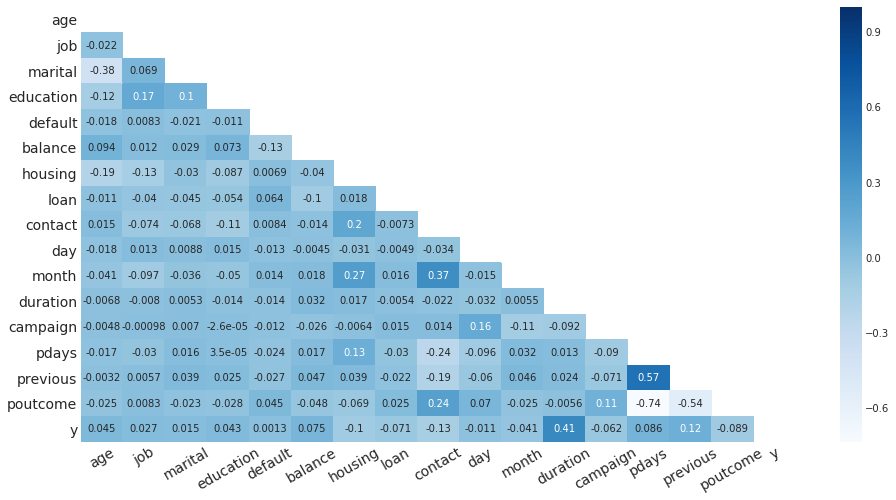

In [24]:
corrs = new_df.corr()
fig, ax = plt.subplots(figsize=(16,8))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask, annot=True, cmap="Blues")

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

#### As shown by the heat map there is very little correlation between the features of the dataset and the target

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
#what's my baseline?
new_df.y.mean() #My baseline is very low, so even a good model will not have much predictive power (11.5% 'yes')

0.11523999115239991

In [27]:
X = new_df[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'age', 'pdays', 'balance', 'day', 'poutcome', 'previous']]
y = new_df['y']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [29]:
lr = LogisticRegression()
lr.fit(X_train, y_train, )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
lr.score(X_test, y_test)

0.87925696594427249

In [31]:
import seaborn as sb

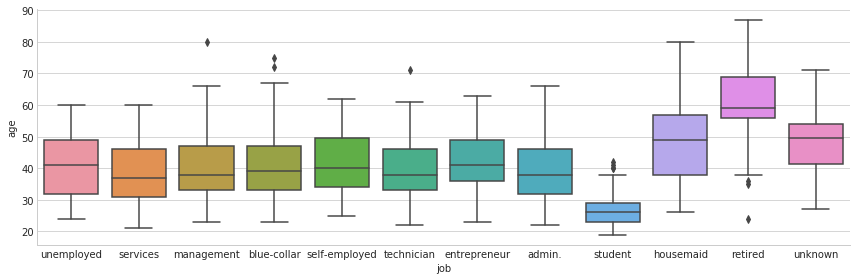

In [32]:
sb.factorplot(
    x='job',
    y='age',
    data=bank_data, 
    kind='box',
    size = 4,
    aspect = 3
)

#### The above factor plot shows thats certain ages ranges are must more likely to have a particular job. E.g. Students are usually younger than 30, which makes a lot of sense. Also retired persons are typically older than 55.

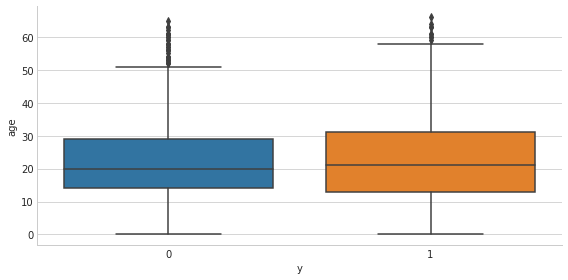

In [33]:
sb.factorplot(
    x='y',
    y='age',
    data=new_df, 
    kind='box',
    size = 4,
    aspect = 2
)

#### The above factor plots shows there is a wider range of ages that subscribe to a term deposit than the range of ages that did not subscribe. This suggests there may be a relationship between age groups that relate to an employment status (the age of students) and the outcome. 
- Persons who fit into the category of a student are less likely to subscribe to a term deposit.

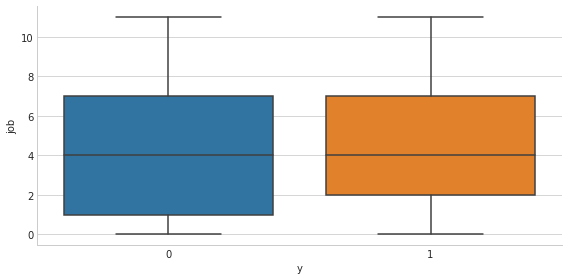

In [34]:
sb.factorplot(
    x='y',
    y='job',
    data=new_df, 
    kind='box',
    size = 4,
    aspect = 2
)

In [35]:
for x in range(2,8):
    print d['job'].inverse_transform([x])

['entrepreneur']
['housemaid']
['management']
['retired']
['self-employed']
['services']


### Above shows which job titles are more likely to subscribe to a term deposit

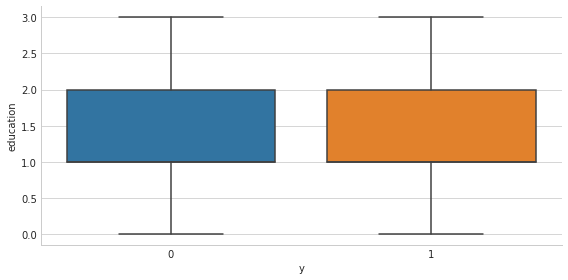

In [36]:
sb.factorplot(
    x='y',
    y='education',
    data=new_df, 
    kind='box',
    size = 4,
    aspect = 2
)

### Given that there is an exact match on the plots above the feature education will not be useful in predictions

# Part 4
# More Question that have arisen
- how does running a model improve my baseline
- get best logistic regression by running gridsearch to determin best regularization

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_df = pd.DataFrame(X_scaled,columns=X.columns)
X_df.head()

,job,marital,education,default,housing,loan,contact,month,age,pdays,balance,day,poutcome,previous
0,1.716804,-0.246429,-1.644755,-0.130759,-1.142051,-0.424756,-0.723642,1.485414,-1.056886,-0.397524,0.916941,0.374052,0.386938,-0.325061
1,0.795246,-0.246429,-0.309038,-0.130759,0.875617,2.354292,-0.723642,0.819288,-0.772983,3.175235,1.793905,-0.596026,-2.767880,2.083131
2,-0.126313,1.421396,1.026680,-0.130759,0.875617,-0.424756,-0.723642,-1.845220,-0.583715,3.034205,0.645162,0.010273,-2.767880,0.276987
3,-0.126313,-0.246429,1.026680,-0.130759,0.875617,2.354292,1.495133,0.153161,-1.056886,-0.397524,0.722587,-1.566105,0.386938,-0.325061
4,-1.047871,-0.246429,-0.309038,-0.130759,0.875617,-0.424756,1.495133,0.819288,1.687510,-0.397524,-0.980777,-1.323585,0.386938,-0.325061


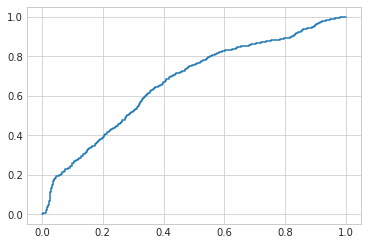

In [40]:
predictions = lr.predict(X_df)
probabilities = lr.predict_proba(X_df)
plt.plot(roc_curve(y, probabilities[:,1])[0],
         roc_curve(y, probabilities[:,1])[1])
plt.show()

In [43]:
roc_auc_score(y, lr.predict(X_df))

0.61070585412667944

<a id='gridsearch' ></a>
## Gridsearch searching for best alpha penalty

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold

In [45]:
# Use GridSearch to try different params for LogisticRegression;
search_parameters = { 
    "C": np.linspace(10**(-10), 0.25, 200)
}
lasso = LogisticRegression(penalty='l1')# type of penalty applied to LR

estimator = GridSearchCV(lasso, search_parameters, scoring="accuracy")
results = estimator.fit(X_df, y) # using standardized feature set in fitting

In [46]:
results_df = pd.DataFrame(estimator.cv_results_)
results_df.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.004008,0.000635,0.88476,0.88476,1e-10,{u'C': 1e-10},1,0.884615,0.884832,0.884539,0.884871,0.885126,0.884577,0.000985,0.000044,0.000261,0.00013
1,0.004295,0.000610,0.88476,0.88476,0.00125628,{u'C': 0.00125628150653},1,0.884615,0.884832,0.884539,0.884871,0.885126,0.884577,0.000146,0.000015,0.000261,0.00013
2,0.004990,0.001259,0.88476,0.88476,0.00251256,{u'C': 0.00251256291307},1,0.884615,0.884832,0.884539,0.884871,0.885126,0.884577,0.000193,0.000459,0.000261,0.00013
3,0.006433,0.001147,0.88476,0.88476,0.00376884,{u'C': 0.0037688443196},1,0.884615,0.884832,0.884539,0.884871,0.885126,0.884577,0.000602,0.000346,0.000261,0.00013
4,0.004974,0.000737,0.88476,0.88476,0.00502513,{u'C': 0.00502512572613},1,0.884615,0.884832,0.884539,0.884871,0.885126,0.884577,0.000408,0.000041,0.000261,0.00013


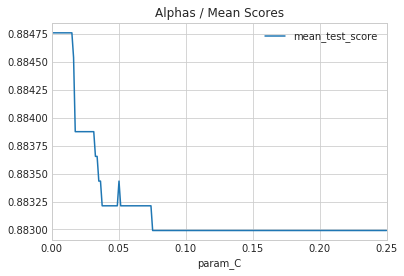

In [47]:
results_df.plot(x="param_C", y="mean_test_score", title="Alphas / Mean Scores")
plt.show()

In [47]:
print "Best Score", results.best_score_ #best score of models fitted by GS
print "Best Params with fit_intercept included as search param", results.best_params_ #Best C param

Best Score 0.884760008848
Best Params with fit_intercept included as search param {'C': 1e-10, 'fit_intercept': True}


In [43]:
# Use GridSearch to try different params for LogisticRegression;
search_parameters = {
    "C": np.linspace(10**(-10), 0.25, 200)
}
lasso = LogisticRegression(penalty='l1')# type of penalty applied to LR

estimator = GridSearchCV(lasso, search_parameters, scoring="accuracy")
results = estimator.fit(X_df, y) # using standardized feature set in fitting

In [44]:
print "Best Score", results.best_score_ #best score of models fitted by GS
print "Best Params with only l1 penalty for lasso logit", results.best_params_ #Best C param

Best Score 0.884760008848
Best Param {'C': 1e-10}


<a id='findings'></a>
### Best Score is 88% TP rate with a baseline of 11% success